# Visualizing CAM-SE grids
The CAM-SE dynamical core carries around data stored at Gauss-Lobatto-Legendre (GLL) nodes. Mark Taylor has a nice description of the different ways of interpreting the native grid [here](https://acme-climate.atlassian.net/wiki/display/Docs/Atmosphere+Grids). There are basically three different ways of interpreting the grid, and these are represented in three different grid files used by various utilities in CAM/CESM/ACME:

In [1]:
# data locations
files = {
    'scrip': '/home/bhillma/data/acme/grids/twpx4v1/grid_files/twpx4v1np4b_scrip_170613.nc',
    'latlon': '/home/bhillma/data/acme/grids/twpx4v1/grid_files/twpx4v1np4b_latlon_170613.nc',
    'exodus': '/home/bhillma/data/acme/grids/twpx4v1/grid_files/twpx4v1.g',
}

The most intuitive is probably the grid represented by the SCRIP file, where the grid is defined by cell centers that correspond to the Gauss-Lobatto-Legendre (GLL) nodes, with vertices that define emcompassing polygon cells with areas that reproduce the GLL-weights used by the internal CAM-SE dynamical core. We can plot the cell centers and the emcompassing polygons for the TWP grid we have created for ACME:

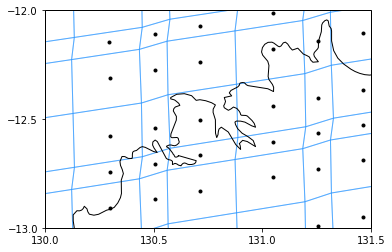

In [2]:
%matplotlib inline

# set bounds for the map area we want to look at
x1, x2 = 130, 131.5
y1, y2 = -13, -12
xticks = [130, 130.5, 131, 131.5]
yticks = [-13, -12.5, -12]

# open dataset as an xarray dataset object
from xarray import open_dataset
with open_dataset(files['scrip']) as ds:
        
    # keep just the data within the range we want to look at
    # add a bit of a buffer around the endpoints
    ds = ds.where(
        (ds.grid_center_lon >= x1-10) & (ds.grid_center_lon <= x2+10) & 
        (ds.grid_center_lat >= y1-10) & (ds.grid_center_lat <= y2+10)
    )
    ds = ds.dropna('grid_size')
    
    # we want to plot the cell centers as dots, and the cell edges as polygons
    # use the cartopy library to do the mapping for us
    from cartopy import crs
    
    # setup the figure and map axes
    from matplotlib import pyplot, patches
    figure = pyplot.figure()
    ax = pyplot.subplot(111, projection=crs.PlateCarree())
    
    # limit axes extent to zoom in on specific area
    ax.set_extent([x1, x2, y1, y2], crs=crs.PlateCarree())
    ax.set_xticks(xticks, crs=crs.PlateCarree())
    ax.set_yticks(yticks, crs=crs.PlateCarree())
    
    # plot a high resolution coastline for reference
    ax.coastlines(resolution='10m')
    
    # plot GLL nodes (grid centers in the scrip "dual grid" files) as points
    pl = ax.plot(ds['grid_center_lon'], ds['grid_center_lat'], 'k.')
    
    # plot the dual grid cell boundaries for each GLL node
    # need numpy to combine arrays
    import numpy
    for ielement in range(ds.dims['grid_size']):
        
        # get grid corners
        x_corners = ds['grid_corner_lon'][ielement, :]
        y_corners = ds['grid_corner_lat'][ielement, :]

        # create polygons
        vertices = numpy.column_stack([x_corners, y_corners])
        patch = patches.Polygon(
            vertices, closed=True, 
            facecolor='none', edgecolor='dodgerblue', alpha=0.5,
            transform=crs.PlateCarree(),
        )
        ax.add_patch(patch)

    # optionally fill with grid cell area
    #pl = ax.tricontourf(ds['grid_center_lon'], ds['grid_center_lat'], ds['grid_area'], transform=crs.PlateCarree())
    
    # save figure
    figure.savefig('../graphics/twp_scrip_dualgrid.pdf', bbox_inches='tight')

We can also plot the area of each GLL node as a sanity check:

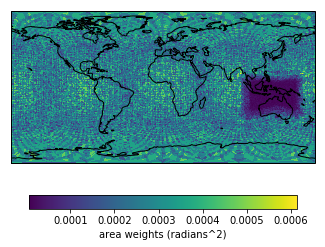

In [3]:
# open dataset as an xarray dataset object
from xarray import open_dataset
with open_dataset(files['scrip']) as ds:
        
    # we want to plot the cell centers as dots, and the cell edges as geodesics
    # use the cartopy library to do the mapping for us
    from cartopy import crs
    
    # setup the figure and axis
    from matplotlib import pyplot
    figure = pyplot.figure()
    ax = pyplot.subplot(111, projection=crs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    
    # plot grid area
    pl = ax.tripcolor(ds['grid_center_lon'], ds['grid_center_lat'], ds['grid_area'], transform=crs.PlateCarree())
    
    # add a colorbar
    cb = pyplot.colorbar(
        pl, orientation='horizontal', 
        label='%s (%s)'%(ds['grid_area'].long_name, ds['grid_area'].units),
        shrink=0.8,
    )